In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geocube.api.core import make_geocube
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from shapely.geometry import Point
from statsmodels.tsa.seasonal import STL
import xarray as xr

In [2]:
pd.set_option('display.max_rows', 500)

## Pixel level data

### Density and exposure map

In [3]:
# Open pollution dataset – we will use the raw data as it's smaller in size and easier to plot,
# as it didn't go through rescaling to fit small nuts3 regions
forecast = xr.open_dataset("../output/5.europe-forecast-reprojected.netcdf", decode_coords='all')
forecast = forecast.sel(time="2022")
forecast = forecast.resample(time="Y").mean().squeeze()

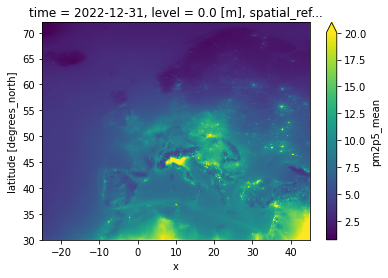

In [4]:
forecast.pm2p5_mean.plot(vmax=20)

In [41]:
# Open GHSL dataset
ghsl = xr.open_dataset("../output/5.ghsl-europe-forecast-reprojected.netcdf", decode_coords='all').squeeze()

In [8]:
# Nuts
nuts = gpd.read_file("../output/NUTS/expanded-NUTS.json")
nuts = nuts[nuts.LEVL_CODE==0]

In [43]:
# Ensures that the data is properly sorted
forecast = forecast.sortby(['x', 'y'])
ghsl = ghsl.sortby(['x', 'y'])

In [44]:
ghsl

<xarray.Dataset>
Dimensions:      (x: 700, y: 420)
Coordinates:
  * x            (x) float32 -24.95 -24.85 -24.75 -24.65 ... 44.75 44.85 44.95
  * y            (y) float32 30.05 30.15 30.25 30.35 ... 71.65 71.75 71.85 71.95
    band         int64 1
    spatial_ref  int64 0
    level        float32 0.0
Data variables:
    band_data    (y, x) float64 ...

In [45]:
# Gets zones
def get_zones(raster, vector, varname, keyname='region_code'):
    """
    Attributes each grid cell of a raster to a unique ID based on intersection with vector polygons. The function 
    allows to optionally include time as a coordinate and also returns a correspondence dictionary for easier access.
    
    Parameters
    ----------
    raster : xr.DataArray
        The input raster data. 
    vector : gpd.GeoDataFrame
        The input vector data. It should be filtered and have the keyname column assigned.
    varname : str
        The name of the variable in the raster to use in the output grid – 
    keyname : str, optional
        A string representing the column values that will be added to the output grid, 
        marking to which polygon each pixel belongs. Defaults to 'region_code'.

    
    Returns
    -------
    outgrid : xr.Dataset
        The output grid with grid cells marked with unique IDs. If 'time' is True, time is also included as a coordinate.
    corresp : dict
        A correspondence dictionary mapping unique polygon IDs to the respective 'keyname' values for easy access.
        
    Notes
    -----
    This docstring was created with the help of GPT-4, an AI language model developed by OpenAI.
    """

    
    # Saves the for afterwards
    time_dim = raster.time
    
    # Keeps only the variable of interest
    raster = raster[varname]
        
    # Creates a key to mark the grid cells with
    vector[keyname] = range(0, vector.shape[0]) # in geocube, the ids need to be numbers :/
      
    # A correspondence dict for easier access
    corresp = {row["NUTS_ID"]: row[keyname] for index, row in vector[[keyname, 'NUTS_ID']].iterrows()}
    
    # Creates an output grid – that is, an xarray representation of the vector data
    # but with no values associated
    outgrid = make_geocube(
        vector_data=vector, # The shapes that we will use as a mold
        measurements=[keyname], # This is the LABEL we will stamp the pixels with
        like=raster, # The new cube will have the shape of the raster
    )
    
    return outgrid, corresp

In [46]:
outgrid, corresp = get_zones(forecast, nuts, varname='pm2p5_mean')

In [47]:
# Attributes region codes to CAMS
outgrid = outgrid.assign_coords({"x": forecast.x, "y": forecast.y})
forecast['region_code'] = outgrid.region_code

In [48]:
# Attributes population to each cell
ghsl = ghsl.assign_coords({"x": forecast.x, "y": forecast.y})
forecast['population'] = ghsl.band_data

In [49]:
# Make it a dataframe
gdf = forecast.to_dataframe().reset_index()

In [50]:
# We should only plot populated places
gdf = gdf[gdf.population > 0]

In [51]:
# Creates a geometry column
geometry = gdf.apply(lambda row: Point(row.x, row.y), axis=1)
gdf = gpd.GeoDataFrame(gdf, geometry=geometry)
gdf = gdf.set_crs("EPSG:4326")

In [52]:
def min_max_normalize(arr, min_val=0, max_val=1, cap_min=None, cap_max=None):
    if cap_min is not None:
        arr = np.where(arr < cap_min, cap_min, arr)
    if cap_max is not None:
        arr = np.where(arr > cap_max, cap_max, arr)

    min_arr = cap_min if cap_min is not None else np.min(arr)
    max_arr = cap_max if cap_max is not None else np.max(arr)
    if min_arr == max_arr:
        return np.full(arr.shape, (min_val + max_val) / 2)
    else:
        return min_val + (arr - min_arr) * (max_val - min_val) / (max_arr - min_arr)


In [53]:
def log_normalize(data):
    # Returns values from 0 to 1
    return (np.log(data) - np.log(data.min())) / (np.log(data.max()) - np.log(data.min()))

In [54]:
def get_color(val):
    if val < 5:
        return '#00a5ff' # blue 1
    elif 5 <= val < 10:
        return '#dee500' # yellow
    elif 10 <= val < 15:
        return '#eb6e14' # orange
    else: # 15+
        return  '#be232d'# red

In [55]:
def plot_map(gdf, size_caps=None):

    # Set up the plot with Cartopy's PlateCarree projection
    fig, ax = plt.subplots(1, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set the background color
    ax.set_facecolor("#f1f3f5")

    # Add the country boundaries feature from Cartopy
    countries = cfeature.NaturalEarthFeature(category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='#e4e8eb')
                                             #edgecolor='#323c45')
    ax.add_feature(countries)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5, zorder=9999)
    ax.add_feature(cfeature.COASTLINE, zorder=9999)

    ax.set_ylim(gdf.y.min(), gdf.y.max())
    ax.set_xlim(gdf.x.min(), gdf.x.max())

    gdf['color'] = gdf.pm2p5_mean.apply(get_color)
    
    if not size_caps:
        gdf['population_scale'] = min_max_normalize(gdf['population'], .03, 100, cap_min=10, cap_max=1000000)
        gdf['population_alpha'] = min_max_normalize(gdf['pm2p5_mean'], .3, 1, cap_min=10, cap_max=1000000)
    if size_caps:
        # When adjusting size caps in smaller regions, we get rid of alpha values
        gdf['population_scale'] = min_max_normalize(gdf['population'], .01, 100, cap_min=size_caps[0], cap_max=size_caps[1])
        gdf['population_alpha'] = .8

    gdf.plot(color=gdf.color,
             edgecolor=gdf.color,
             markersize=gdf.population_scale,
             #alpha=1,
             alpha=gdf.population_alpha, 
             ax=ax, legend=True, legend_kwds={'label': "Pollution Level"}, zorder=9998)

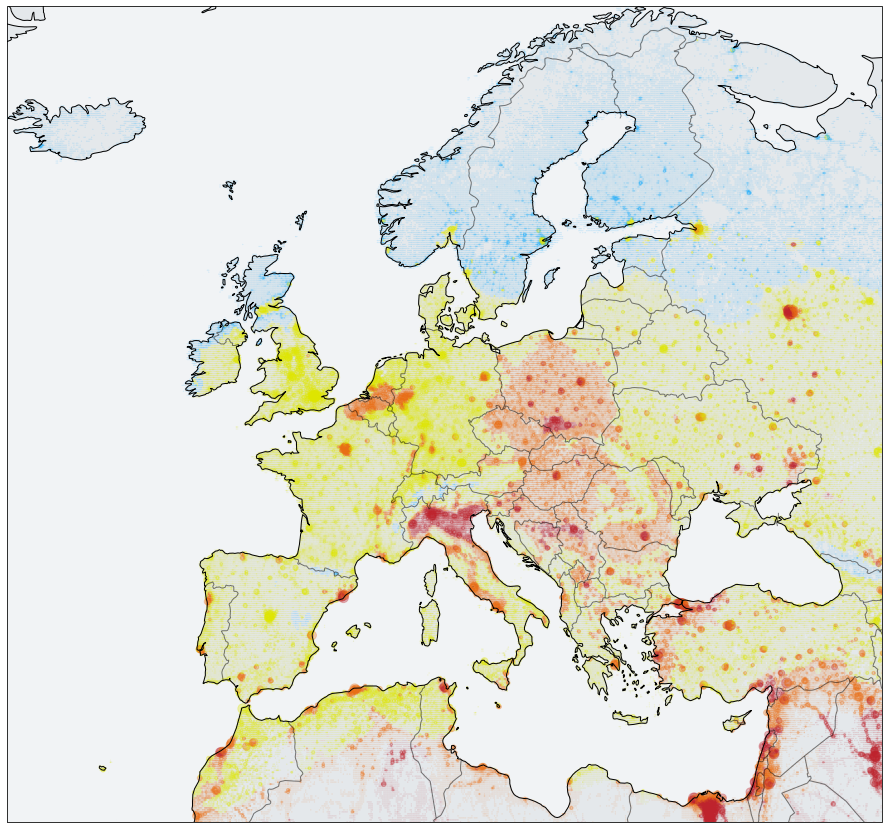

In [56]:
plot_map(gdf)

25 250000


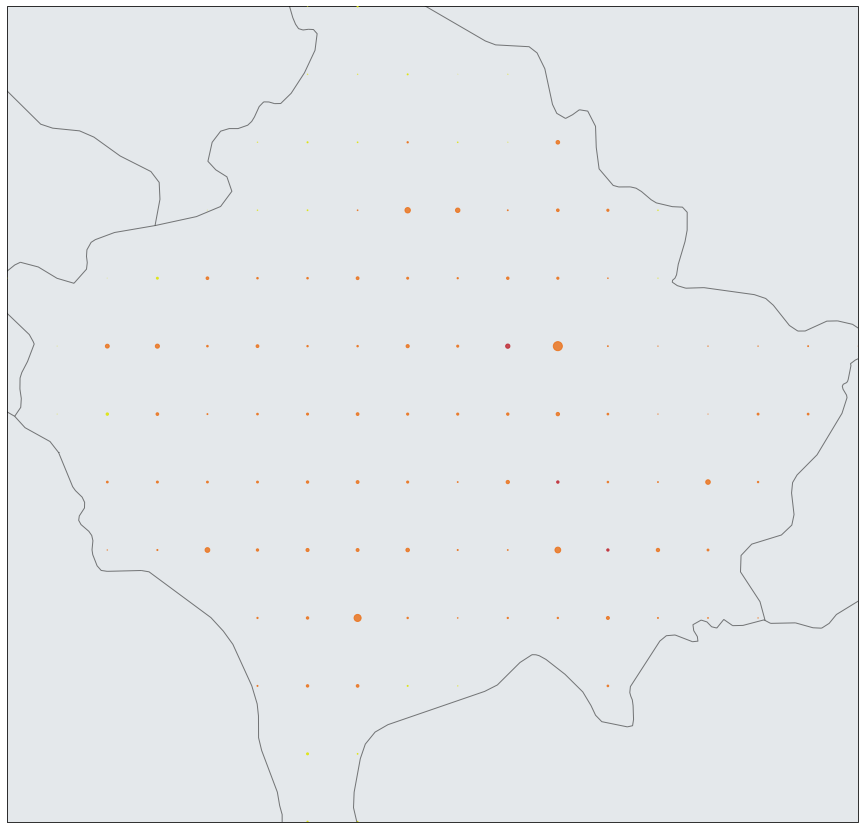

In [62]:
def plot_subset(gdf, region_code):
    
    # Total pop
    pop_whole = gdf.population.sum()
    
    # Filters
    gdf = gdf[gdf.region_code==region_code]
    
    # Get country population
    pop_country = gdf.population.sum()
    
    # Gets a ratio for adjusting largest dot
    ratio = pop_country / pop_whole
    max_cap = 250000
    min_cap = 25
    print(min_cap, max_cap)
    
    # Max cap is adjusted by the ratio of general max cap and the total
    plot_map(gdf[gdf.region_code==region_code], size_caps=(min_cap, max_cap))
    
plot_subset(gdf, corresp['XKO'])

In [61]:
corresp

{'FR': 0,
 'HR': 1,
 'HU': 2,
 'AL': 3,
 'AT': 4,
 'BE': 5,
 'BG': 6,
 'CH': 7,
 'CY': 8,
 'CZ': 9,
 'DE': 10,
 'DK': 11,
 'EE': 12,
 'EL': 13,
 'IE': 14,
 'ES': 15,
 'FI': 16,
 'IS': 17,
 'PT': 18,
 'RO': 19,
 'RS': 20,
 'SE': 21,
 'SI': 22,
 'SK': 23,
 'TR': 24,
 'UK': 25,
 'NO': 26,
 'IT': 27,
 'LI': 28,
 'LT': 29,
 'LU': 30,
 'LV': 31,
 'ME': 32,
 'MK': 33,
 'MT': 34,
 'NL': 35,
 'PL': 36,
 'UKR': 37,
 'XKO': 38,
 'BIH': 39,
 'MDA': 40}